## Training CNN on CIFAR10 Dataset [1]

We begin with building a CNN architecture for image classification task on CIFAR10 dataset. In this part of the tutorial, we will understand how to arrange the different architectural components of CNN network, defining the appropriate loss, training the network using backpropagation and finally testing it on the test data.

To make data loading simple, we would use the torchvision package created as part of PyTorch which has data loaders for standard datasets such as ImageNet, CIFAR10, MNIST.

### CIFAR10 dataset
![CIFAR10](images/cifar10.png)

### Required Packages

In [1]:
#a Tensor library with GPU support
import torch

#Datasets, Transforms and Models specific to Computer Vision
import torchvision
import torchvision.transforms as transforms

#differentiation library that supports all differentiable Tensor operations in torch
from torch.autograd import Variable

#a neural networks library integrated with autograd functionality
import torch.nn as nn
import torch.nn.functional as F

#an optimization package with standard optimization methods such as SGD, RMSProp, LBFGS, Adam etc.
import torch.optim as optim

#scientific computing library for Python
import numpy as np

#plotting and visualization library
import matplotlib.pyplot as plt
#Display on the notebook
%matplotlib inline 
plt.ion() #Turn interactive mode on.

### Dataloader and Transformers

In [2]:
####train data
#Compose transforms (applies data transformation and augmentation) prior to feeding to training
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#inbuilt dataset class for reading CIFAR10 dataset
trainset = torchvision.datasets.CIFAR10(root='../../data/lab1', train=True,
                                        download=False, transform=transform)

#dataloader for Batching, shuffling and loading data in parallel
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

####test data
testset = torchvision.datasets.CIFAR10(root='../../data/lab1', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

#### Visualizing the dataset images

('GroundTruth: ', '  cat  ship  ship plane')


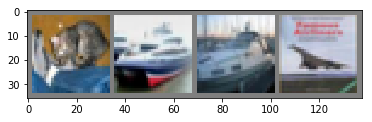

In [3]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

### Defining the CNN architecture
![cnn-arch](images/cnn-arch.png)
#### Basic Convolutional Layer
![conv](images/conv-all.png)

To create a network, we should first inhert the base class nn.Module. You just have to define the forward function, and the backward function (where gradients are computed) is automatically defined for you using autograd. You can use any of the Tensor operations in the forward function.

In [5]:
class Net(nn.Module):
    
    #define the learnable paramters by calling the respective modules (nn.Conv2d, nn.MaxPool2d etc.)
    def __init__(self):
        super(Net, self).__init__()
        
        #calling conv2d module for convolution
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5,stride=1,padding=0,bias=True)
        
        #calling MaxPool2d module for max pooling with downsampling of 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        #fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    #defining the structure of the network
    def forward(self, x):
        
        #Applying relu activation after each conv layer
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        #reshaping to 1d for giving input to fully connected units
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

#Printing the network architecture
print(net)


Net (
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear (400 -> 120)
  (fc2): Linear (120 -> 84)
  (fc3): Linear (84 -> 10)
)


In [9]:
#Printing the parameter values
params = list(net.parameters())
print(params[1].size())  # conv1's .weight

torch.Size([6])


#### Forward Pass

In [6]:
input = Variable(torch.randn(1, 3, 32, 32))
out = net(input)
print(out)

Variable containing:
 0.0363  0.1553 -0.0068 -0.0810 -0.0012  0.0536 -0.0225  0.0082  0.0878  0.0417
[torch.FloatTensor of size 1x10]



#### Backward Pass

In [7]:
net.zero_grad()
out.backward(torch.randn(1, 10))

#### Loss Function
In this example, we will use Classification Cross-Entropy loss and SGD with momentum.<br>
Cross Entropy loss is given as:- $L=-\sum_i y_i \log(p_i)$ and $p_i=\frac{\exp^{x_i}}{\sum_k \exp^{x_k}}$

There are many other loss functions such as MSELoss, L1Loss etc. Visit [here](http://pytorch.org/docs/master/nn.html#loss-functions) for other loss functions.

#### Stochastic Gradient Descent (SGD)
$$w_{n+1} = w_{n} - \eta \triangle$$
$$\triangle = 0.9\triangle + \frac{\partial L}{\partial w}$$

Although SGD is the most popular and basic optimizer that one should first try. There are many adaptive optimizers like Adagrad,Adadelta RMSProp and many more. Visit [here](http://pytorch.org/docs/master/optim.html) for other examples.

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

#### Training in mini-batches

[1,  2000] loss: 2.183
[1,  4000] loss: 1.824
[1,  6000] loss: 1.694
[1,  8000] loss: 1.604
[1, 10000] loss: 1.536
[1, 12000] loss: 1.472


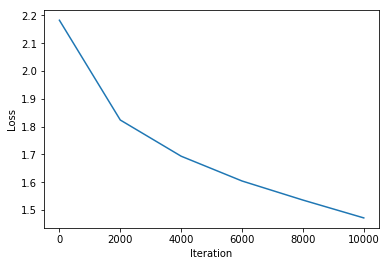

Finished Training


In [9]:
plotIter = 2000
plotIterCntr = 0
numEpochs = 1
trainLoss = np.zeros((plotIter*numEpochs,1))
trainIter = np.arange(plotIter*numEpochs)

#Transferring the model to GPU
net.cuda()

for epoch in range(numEpochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if i % plotIter == plotIter-1:    # print every plotIter mini-batches
            trainLoss[plotIterCntr] = running_loss / plotIter
            plotIterCntr+=1
            
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / plotIter))
            running_loss = 0.0
 
#Plotting the training graph
plt.plot(np.arange(plotIterCntr)*plotIter,trainLoss[0:plotIterCntr], label="train")
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

print('Finished Training')

#### Forward Pass over the trained network

In [10]:
outputs = net(Variable(images).cuda())
_, predicted = torch.max(outputs.data, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j][0]]
                              for j in range(4)))

Predicted:    cat  ship  ship  ship


#### Test Accuracy 

In [11]:
## Prediction of accuracy
correct = 0
total = 0

#Iterating over the batches returned from testloader
for data in testloader:
    images, labels = data
    outputs = net(Variable(images.cuda()))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    labels = labels.cuda()
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the 10000 test images: 50 %


#### Hyperparameters -- Learning Rate
![lR](images/learning-rate.png)
Typically learning rates are set using step decay, exponential/log space decay and manually.

##### Self Exercise -1
- Manipulate the learning rates in range of 10-0.0001, momentum from (0.5,0.9) and understand how the training proceeds.
- Check the performance by changing:-
    - Add two more conv layers and check the training performance.
    - Optimizer to Adagrad and check the performance.
    - Modify the loss function to MSELoss.

### Visualization of Layers
To undestand what is being learnt in the filters, we now visualize the weights. Here we restrict ourselves to conv1 layer which contains 3d filters and can be visualized in the image space itself. For visualizing layers other that first one, read [3] and the follow up papers taught in class.

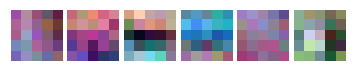

In [12]:
#### Visualization of Layer 1 weights
def plot_kernels(tensor, num_cols=6):
    if not tensor.ndim==4:
        raise Exception("assumes a 4D tensor")
    if not tensor.shape[-1]==3:
        raise Exception("last dim needs to be 3 to plot")
    num_kernels = tensor.shape[0]
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))
    for i in range(tensor.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        ax1.imshow(tensor[i])
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()
    
net_cpu = net.cpu()

#Reading the conv1 weights
dat = net_cpu.conv1.weight.data.numpy()

#Normalizing the weights from (0,1)
maxVal = dat.max()
minVal = abs(dat.min())
maxVal = max(maxVal,minVal)
dat = dat / maxVal
dat = dat / 2
dat = dat + 0.5

#calling visualization function
plot_kernels(dat.transpose((0,2,3,1)))

#### Generalization using Dropouts
Dropouts perform a stochastic regularization by dropping out hidden units randomly with fixed probability $p$ while training and while testing the all units are preserved but scaled with $p$.
![dropouts](images/dropout.png)

#### Batch Normalization 
Normalize the output feature maps across samples in a mini-batch. 

In [13]:
class Net_DB(nn.Module):
    def __init__(self):
        super(Net_DB, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        
        #applying batch normalization
        self.conv1_bn = nn.BatchNorm2d(num_features=6)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
        #Flag to apply droputs only at training
        self.is_training = False

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(self.conv1_bn(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        
        #Applying dropouts
        x = F.dropout(x, p=0.2, training=self.is_training)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net_db = Net_DB()

[1,  2000] loss: 2.169
[1,  4000] loss: 1.828
[1,  6000] loss: 1.682
[1,  8000] loss: 1.604
[1, 10000] loss: 1.533
[1, 12000] loss: 1.480


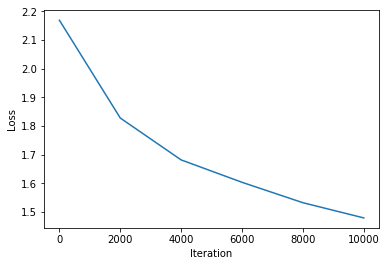

Finished Training with droputs and batch normalization


In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_db.parameters(), lr=0.001, momentum=0.9)

plotIter = 2000
plotIterCntr = 0
numEpochs = 1
trainLoss = np.zeros((plotIter*numEpochs,1))
trainIter = np.arange(plotIter*numEpochs)

net_db.cuda()
net_db.is_training = True

for epoch in range(numEpochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net_db(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if i % plotIter == plotIter-1:    # print every plotIter mini-batches
            trainLoss[plotIterCntr] = running_loss / plotIter
            plotIterCntr+=1
            
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / plotIter))
            running_loss = 0.0
            
plt.plot(np.arange(plotIterCntr)*plotIter,trainLoss[0:plotIterCntr], label="train")
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

print('Finished Training with droputs and batch normalization')



In [15]:
net_db.is_training = False

## Prediction of accuracy
correct = 0
total = 0

for data in testloader:
    images, labels = data
    outputs = net_db(Variable(images.cuda()))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    labels = labels.cuda()
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 50 %


### References
[1] Soumith Chintala, [Deep Learning with PyTorch: A 60 Minute Blitz](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)<br>
[2] [PyTorch documentation](http://pytorch.org/docs/)<br>
[3] Zeiler and Fergus , Visualizing and Understanding Convolutional Networks, ECCV 2014<br>